In [217]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

output_folder = r'output\SMAP_MSL\AnomalyTransformer\10112025_100807'
file_dir = os.path.join(output_folder, 'test_output.pkl')

# Load test_output.pkl
with open(file_dir, "rb") as f:
    test_output = pickle.load(f)

# Define index range
x = np.arange(len(test_output["A_True_Global"]))

# Identify true and predicted anomalies
true_anomalies = test_output.get("A_True_Global", np.zeros_like(x))
pred_anomalies = test_output.get("A_Pred_Global_bf", np.zeros_like(x))
anomalies = np.where(true_anomalies == 1)[0]
pred_anomalies_idx = np.where(pred_anomalies == 1)[0]

Predicted Anomalies index : 
 [   6    9   10 ... 8497 8498 8499]


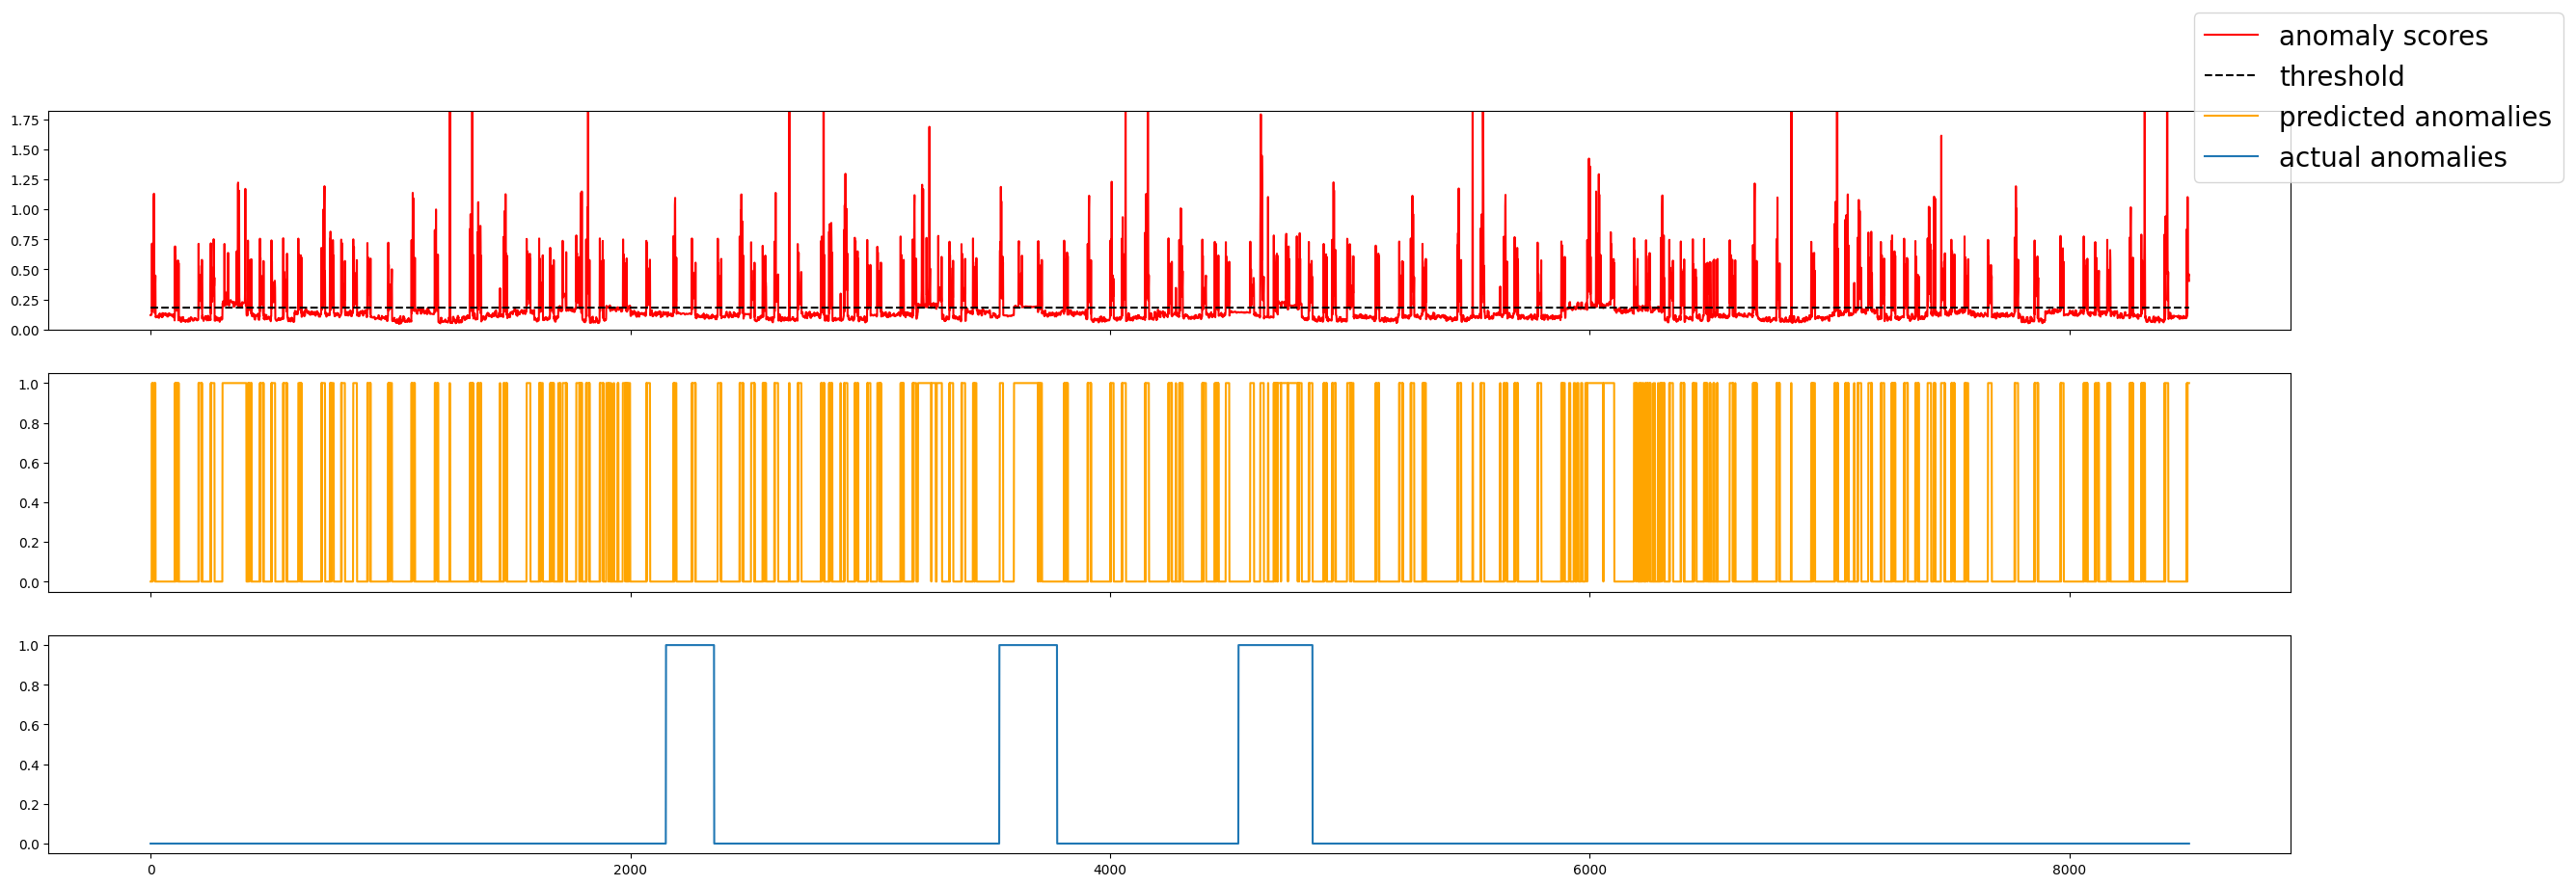

In [218]:
data_copy = test_output.copy()

print(f"Predicted Anomalies index : \n {pred_anomalies_idx}")
fig, axs = plt.subplots(3, figsize=(30, 10), sharex=True)

axs[0].plot(data_copy["A_Score_Global"], c="r", label="anomaly scores")
axs[0].plot(data_copy["Thresh_Global_bf"], linestyle="dashed", c="black", label="threshold")
axs[1].plot(data_copy["A_Pred_Global_bf"], label="predicted anomalies", c="orange")
axs[2].plot(data_copy["A_True_Global"], label="actual anomalies")

axs[0].set_ylim([0, 10 * np.mean(data_copy["Thresh_Global_bf"].values)])
# axs[0].set_ylim([0 , 0.1])
fig.legend(prop={"size": 20})
plt.show()

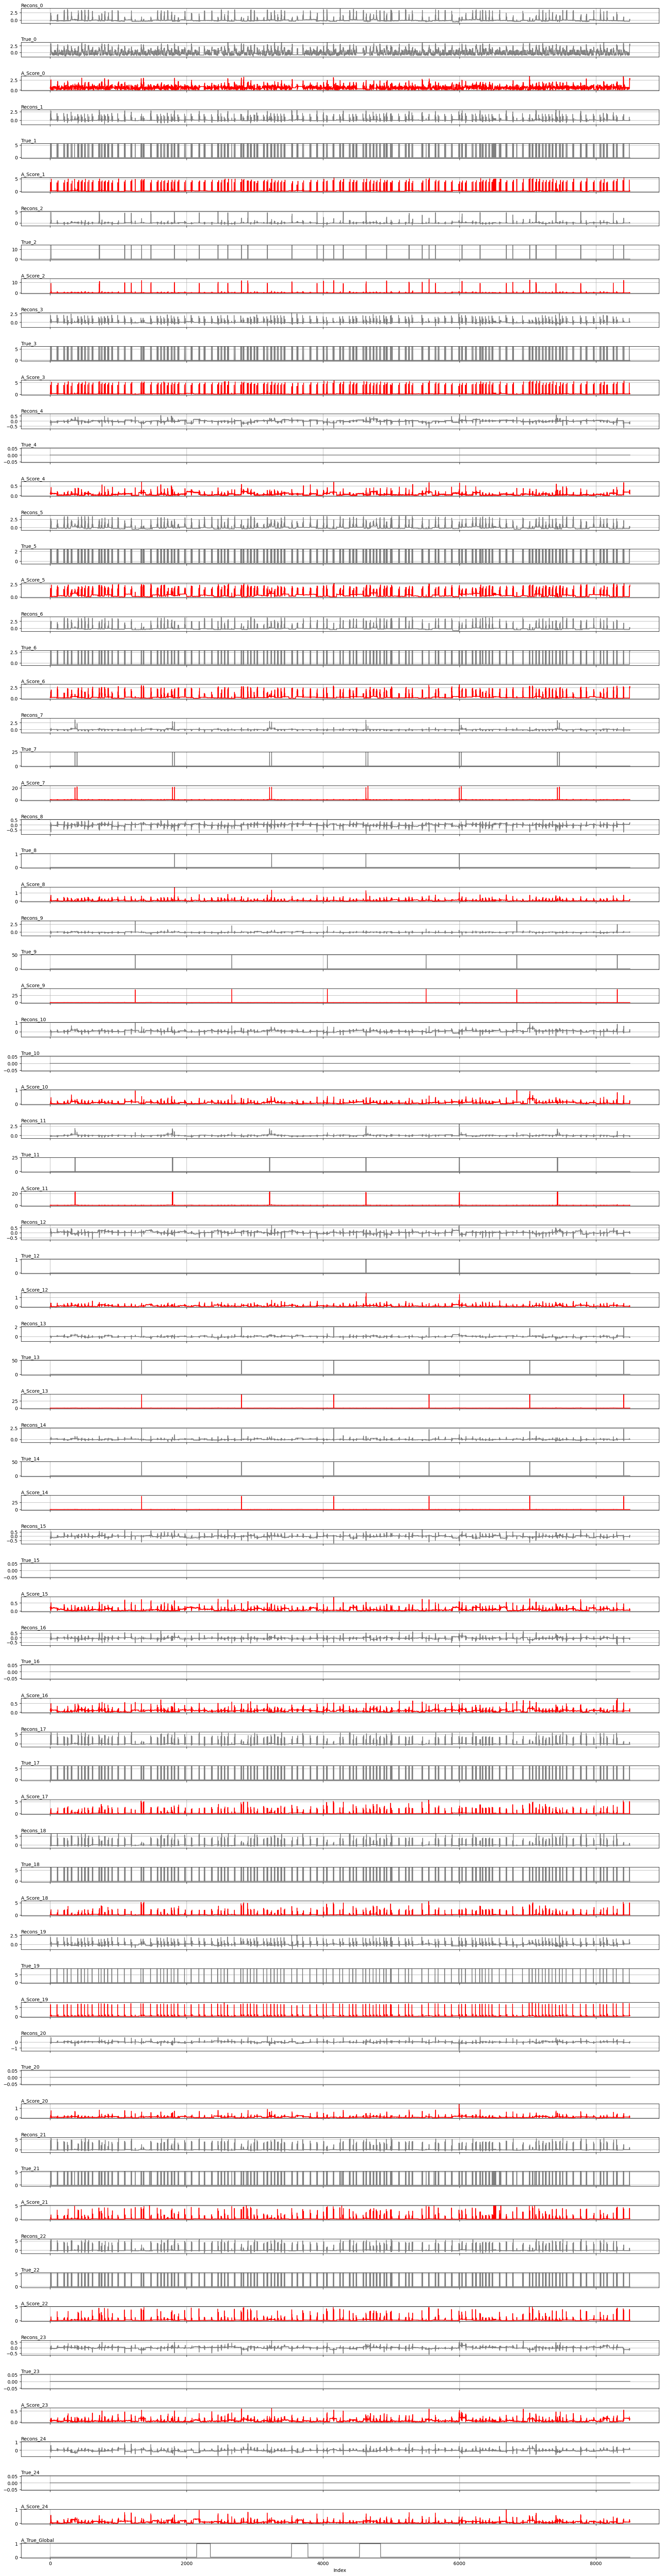

In [219]:
data_copy = test_output.drop(columns=['A_Score_Global', 'Thresh_Global_bf'])
cols = [c for c in data_copy.columns if not (c.startswith('Thresh_') or c.startswith('A_Pred_'))]
data_copy = data_copy[cols]

num_cols = data_copy.shape[1]

fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(20, num_cols), sharex=True)
fig.tight_layout(pad=3.0)

for i, col in enumerate(data_copy.columns):
    ax = axes[i] if num_cols > 1 else axes
    ax.plot(data_copy.index, data_copy[col], color='gray' if 'A_Score' not in col else 'red')
    ax.set_title(col, fontsize=10, pad=3, loc='left')
    
    # ax.set_ylim(-0.1, 1.2)
    ax.grid(True)
            
plt.xlabel("Index")
plt.show()

Text(0.5, 0, 'Index')

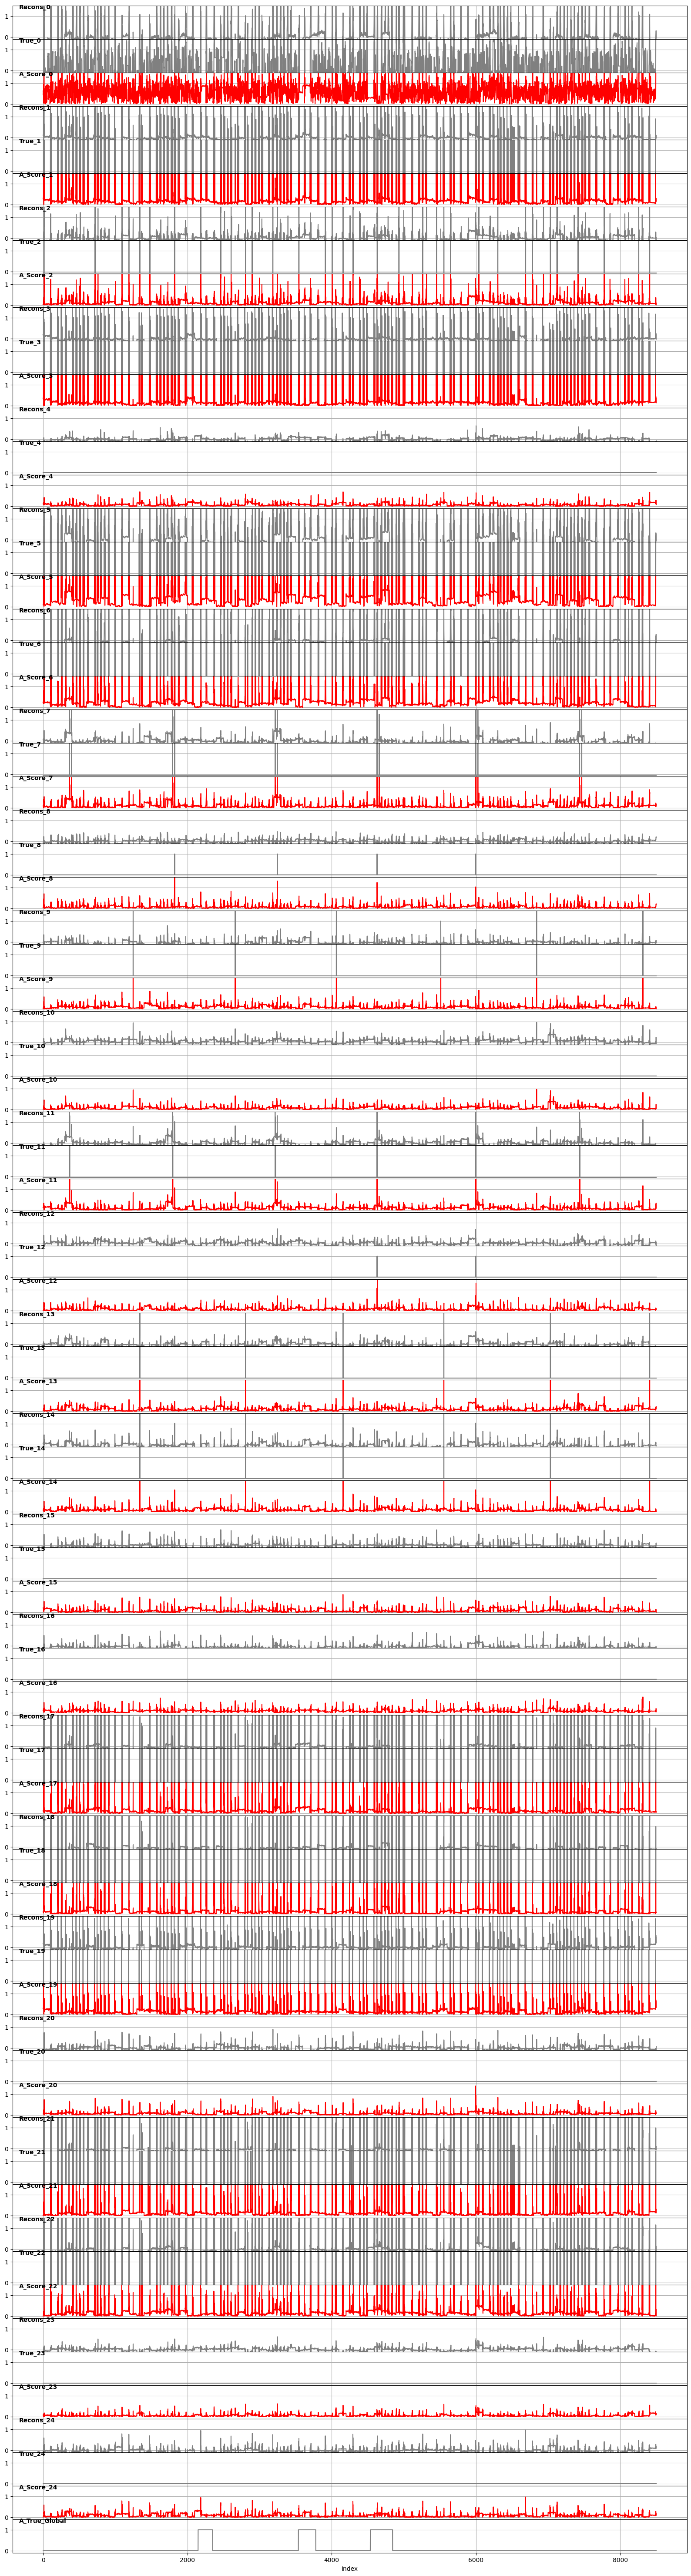

In [220]:
# Replicate the user's data manipulation
data_copy = test_output.drop(columns=['A_Score_Global', 'Thresh_Global_bf'])
cols = [c for c in data_copy.columns if not (c.startswith('Thresh_') or c.startswith('A_Pred_'))]
data_copy = data_copy[cols]

num_cols = data_copy.shape[1]

# Create the figure with subplots
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(20, num_cols), sharex=True)

# Adjust subplot parameters to remove vertical space
plt.subplots_adjust(hspace=0)

# Plotting loop
for i, col in enumerate(data_copy.columns):
    ax = axes[i] if num_cols > 1 else axes
    ax.plot(data_copy.index, data_copy[col], color='gray' if 'A_Score' not in col else 'red')
    # Place sensor name as text inside the plot, non-obtrusively
    ax.text(0.01, 0.9, col, transform=ax.transAxes, fontsize=10, fontweight='bold')
    ax.set_ylim(-0.1, 1.5)
    ax.grid(True)
    
# Set a single xlabel for the shared x-axis on the last subplot
axes[-1].set_xlabel("Index")

In [221]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_anomaly_scores(file_dir, time_index, window_size=None, original_index=False):
    # 1. 데이터 로드
    df = pd.read_pickle(file_dir)

    # 2. index 보정
    if original_index:
        if window_size is None:
            raise ValueError("original_index=True이면 window_size를 반드시 지정해야 합니다.")
        time_index -= window_size

    if time_index < 0 or time_index >= len(df):
        raise IndexError(f"유효하지 않은 시점입니다. 허용 범위: 0 ~ {len(df)-1}")

    # 3. anomaly score 추출
    if not df.filter(like='A_Score_').empty:
        feature_scores = df.filter(like='A_Score_').iloc[time_index]
    elif not df.filter(like='err_scores').empty:
        feature_scores = df.filter(like='err_scores').iloc[time_index]
    else:
        raise ValueError("DataFrame에 'A_Score_' 또는 'err_scores' 컬럼이 없습니다.")

    # 🔹 3-1. Global anomaly 점수 제거
    feature_scores = feature_scores[[col for col in feature_scores.index if "Global" not in col]]

    # 4. 음수 보정
    min_val = feature_scores.min()
    if min_val < 0:
        feature_scores = feature_scores + abs(min_val)

    # 5. 내림차순 정렬
    sorted_scores = feature_scores.sort_values(ascending=False)

    # 6. 라벨 정리 (숫자만 추출)
    clean_labels = [label.replace("A_Score_", "").replace("err_scores_", "") for label in sorted_scores.index]

    # 7. 색상 지정 (상위 2개는 빨간색, 나머지는 원래 colormap)
    base_colors = plt.cm.Blues_r(range(len(sorted_scores)))
    colors = ['red' if i < 3 else base_colors[i] for i in range(len(sorted_scores))]

    # 8. 시각화 (논문용 퀄리티)
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(sorted_scores)), sorted_scores.values, color=colors)

    plt.xticks(range(len(sorted_scores)), clean_labels, rotation=90, fontsize=12)
    plt.yticks(fontsize=12)

    # y축 격자선 추가
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 불필요한 테두리 제거
    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

    return sorted_scores

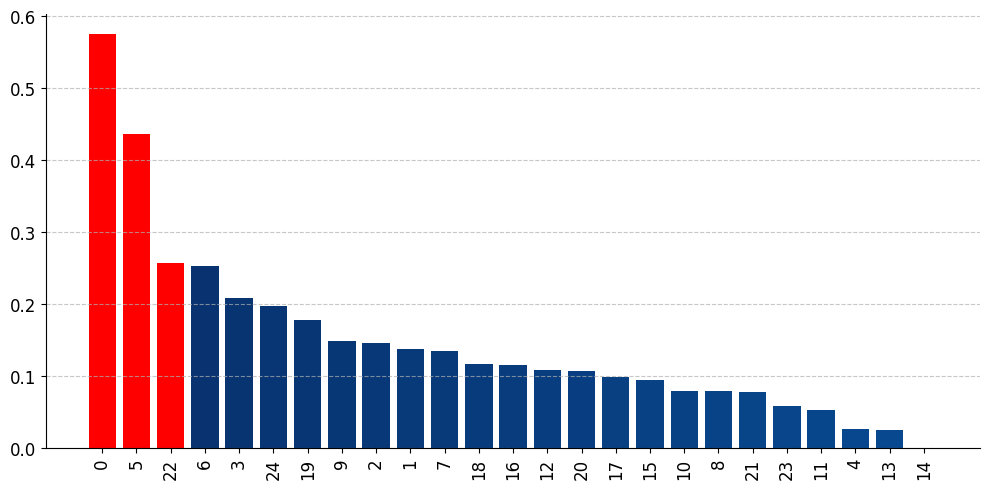


Top 5 Sensors at this time step:
A_Score_0     0.575124
A_Score_5     0.435969
A_Score_22    0.256567
A_Score_6     0.252714
A_Score_3     0.208698
Name: 1550, dtype: float32


In [222]:
file_dir = file_dir
index = 1550
sorted_scores = plot_anomaly_scores(file_dir, index)

print("\nTop 5 Sensors at this time step:")
print(sorted_scores.head(5))